<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex06/Aula6_Marcus_Vinicius_Borela_de_Castro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de uma CNN no CIFAR 10

In [1]:
nome = 'Marcus Vinicius Borela de Castro'

print(f'Meu nome é {nome}')

Meu nome é Marcus Vinicius Borela de Castro


Este exercicío consiste em implementar e treinar no CIFAR-10 vários blocos de uma Resnet seguido de uma camada linear de classificação.

# Preparação Ambiente

## Importação das bibliotecas

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import torch
from torch import nn
from torch import Tensor
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm

## Fixando as seeds

In [3]:
def inicializa_seed(num_semente:int=123):
  """
  É recomendado reiniciar as seeds antes de inicializar o modelo, pois assim
  garantimos que os pesos vao ser sempre os mesmos.
  fontes de apoio: 
      http://nlp.seas.harvard.edu/2018/04/03/attention.html
      https://github.com/CyberZHG/torch-multi-head-attention/blob/master/torch_multi_head_attention/multi_head_attention.py#L15
  """
  random.seed(num_semente)
  np.random.seed(num_semente)
  torch.manual_seed(num_semente)
  #torch.cuda.manual_seed(num_semente)
  #Cuda algorithms
  #torch.backends.cudnn.deterministic = True 

In [4]:
inicializa_seed(123)

## Definindo Hiperparâmetros iniciais

In [5]:
def inicia_hparam()->dict:
  # Inicialização dos parâmetros
  hparam = {}
  hparam['max_epochs'] = 10
  hparam["num_classes"]= 2
  hparam["num_workers_dataloader"] = 2
  hparam['batch_size']= 50
  hparam['early_stop']= 4
  hparam["learning_rate"] = 0.001
  hparam['criterion'] = torch.nn.CrossEntropyLoss()  
  hparam["device"] = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  if torch.cuda.is_available(): print(torch. cuda. get_device_name(hparam["device"]))    
  return hparam

In [6]:
hparam=inicia_hparam()
hparam['batch_size']= 50

Tesla T4


In [7]:
hparam['train_size'] = 40000
hparam['val_size'] = 10000

## Preparando para debug

https://zohaib.me/debugging-in-google-collab-notebook/

In [8]:
!pip install -Uqq ipdb
import ipdb
# %pdb off # desativa debug em exceção
# %pdb on  # ativa debug em exceção

In [9]:
# %xmode Verbose 
# %xmode Plain

## Rastro (neptune.ai)

Gerado rastro da execução no Neptune (detalhes no artigo [Rastro-DM: Mineração de Dados com Rastro](https://revista.tcu.gov.br/ojs/index.php/RTCU/article/view/1664))


### Importação de libraries para Rastro

In [10]:
try:
  import neptune.new as neptune  
except ImportError:
  !pip install neptune-client
  raise Exception('Stopping RUNTIME! Please run again.')



In [11]:
try:
  from torchviz import make_dot 
except ImportError:
  !pip install torchviz
  from torchviz import make_dot 


  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=5e9e68bbca67c4f654633bf28cf6dd1ffdf9bac6aa6061b86bef54d4cd61f9c9
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [12]:
import getpass
import copy
import time
import re
import tempfile
import os


### Código Rastro

Busca implementar o rastro proposto em [Rastro-DM: Mineração de Dados com Rastro](https://revista.tcu.gov.br/ojs/index.php/RTCU/article/view/1664), autores Marcus Vinícius Borela de Castro e Remis Balaniuk, com o apoio da [solução Neptune](https://app.neptune.ai/)



In [13]:
def converte_optimizer_state_dict(parm_optimizer)-> dict:
  # return str(hparam['optimizer'])
  return parm_optimizer.state_dict()['param_groups'][0]

In [14]:
class NeptuneRastroRun():
    se_geracao_rastro = True 
    neptune_project = ""
    tag_contexto_rastro = ""
    neptune_api_token = ""

    def __init__(self, parm_params:dict,  parm_lista_tag:list = None):
      # print(f"NeptuneRastroRun.init: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_params `{parm_params} ")
      if self.__class__.se_geracao_rastro:      
        self.run_neptune = neptune.init(project=self.__class__.neptune_project, api_token=self.__class__.neptune_api_token, capture_hardware_metrics=True)
        self.run_neptune['sys/name'] = self.__class__.tag_contexto_rastro
        vparams = copy.deepcopy(parm_params)
        if "optimizer" in vparams:
          vparams["optimizer"] = converte_optimizer_state_dict(vparams["optimizer"])
        if 'criterion'  in vparams:
          vparams["criterion"] = str(vparams["criterion"])
        if 'device' in vparams:
          vparams['device'] = str(vparams["device"])
        self.device = vparams["device"]
        for tag in parm_lista_tag:
          self.run_neptune['sys/tags'].add(tag)
        self.run_neptune['parameters'] = vparams
        self.tmpDir = tempfile.mkdtemp()

    @property
    def run():
      return self.run_neptune

    @classmethod
    def ativa_geracao_rastro(cls):
     cls.se_geracao_rastro = True      

    @classmethod
    def def_contexto(cls):
     cls.se_geracao_rastro = True      

    @classmethod
    def desativa_geracao_rastro(cls):
     cls.se_geracao_rastro = False      

    @classmethod
    def retorna_status_geracao_rastro(cls):
     return cls.se_geracao_rastro      

    @classmethod
    def retorna_tag_contexto_rastro(cls):
     return cls.tag_contexto_rastro 

    @classmethod
    def inicia_contexto(cls, neptune_project, tag_contexto_rastro, neptune_api_token):
      assert '.' not in tag_contexto_rastro, "NeptuneRastroRun.init(): tag_contexto_rastro não pode possuir ponto, pois será usado para gravar nome de arquivo"      
      cls.neptune_api_token = neptune_api_token
      cls.tag_contexto_rastro = tag_contexto_rastro
      cls.neptune_project = neptune_project

    def salva_metrica(self, parm_metricas={}):
      #print(f"NeptuneRastroRun.salva_metrica: se_geracao_rastro {self.__class__.se_geracao_rastro} parm_metricas:{parm_metricas} ")
      if self.__class__.se_geracao_rastro:
        for metrica, valor in parm_metricas.items(): 
          self.run_neptune[metrica].log(valor)
 
    def gera_grafico_modelo(self, loader_train, model):
      if self.__class__.se_geracao_rastro: 
        # efetuar um forward 
        """
        se dataloader devolver x e y:
        """
        x_, y_ = next(iter(loader_train))
        x_ = x_.to(self.device)
        outputs = model(x_)
        """
        # se dataloader devolver dict:
        dados_ = next(iter(loader_train))
        outputs = model(dados_['x'].to(self.device))
        #outputs = model(x_['input_ids'].to(self.device), x_['attention_mask'].to(self.device))
        """
        nome_arquivo = os.path.join(self.tmpDir, "modelo "+ self.__class__.tag_contexto_rastro + time.strftime("%Y-%b-%d %H:%M:%S"))
        make_dot(outputs, params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render(nome_arquivo, format="png")
        self.run_neptune["parameters/model_graph"].upload(nome_arquivo+'.png')
        self.run_neptune['parameters/model'] = re.sub('<bound method Module.state_dict of ', '',str(model.state_dict))      



    def stop(self):
      if self.__class__.se_geracao_rastro:         
        self.run_neptune.stop()


### Definindo parâmetros para o rastro



In [15]:
NeptuneRastroRun.inicia_contexto('marcusborela/IA025', 'Aula 6 - Resnet',   getpass.getpass('Informe NEPTUNE_API_TOKEN'))
#NeptuneRastroRun.desativa_geracao_rastro()

Informe NEPTUNE_API_TOKEN··········


# Preparação dos dados

## Dataset e dataloader

## Download do CIFAR-10

In [16]:
!mkdir ./data

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Criação do dataloader

In [17]:
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [hparam['train_size'], hparam['val_size']])

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=hparam['batch_size'], shuffle=True, num_workers=hparam["num_workers_dataloader"])
val_dataloader = DataLoader(val_dataset, batch_size=hparam['batch_size'], shuffle=False, num_workers=hparam["num_workers_dataloader"])
test_dataloader = DataLoader(test_dataset, batch_size=hparam['batch_size'], shuffle=False, num_workers=hparam["num_workers_dataloader"])

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 800
Número de minibatches de validação: 200
Número de minibatches de teste: 200

Dimensões dos dados de um minibatch: torch.Size([50, 3, 32, 32])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Investigando o dataset

In [19]:
#fonte: https://www.codetd.com/pt/article/10351232
label_dict_cifar10={0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',
													7:'horse',8:'ship',9:'truck'}

In [20]:
x_train.shape, y_train.shape

(torch.Size([50, 3, 32, 32]), torch.Size([50]))

In [21]:
y_train[0],label_dict_cifar10[y_train[0].item()], x_train[0]

(tensor(5),
 'dog',
 tensor([[[-0.1922, -0.2235, -0.2157,  ..., -0.1608, -0.1529, -0.2078],
          [-0.2392, -0.1529, -0.1451,  ..., -0.2314, -0.2235, -0.1686],
          [-0.1765, -0.2078, -0.1529,  ..., -0.2235, -0.2157, -0.1608],
          ...,
          [-0.2078, -0.1451, -0.0902,  ..., -0.2392, -0.2157, -0.2706],
          [-0.0196, -0.1608, -0.2471,  ..., -0.2000, -0.2549, -0.3255],
          [-0.0118, -0.0510, -0.0275,  ..., -0.2863, -0.2314, -0.2941]],
 
         [[-0.0902, -0.1216, -0.1137,  ..., -0.0431, -0.0431, -0.0980],
          [-0.1294, -0.0510, -0.0431,  ..., -0.1294, -0.1137, -0.0588],
          [-0.0824, -0.1137, -0.0510,  ..., -0.1294, -0.1137, -0.0588],
          ...,
          [-0.2000, -0.1294, -0.0824,  ..., -0.2078, -0.1843, -0.2392],
          [-0.0118, -0.1529, -0.2314,  ..., -0.1686, -0.2235, -0.2863],
          [ 0.0118, -0.0353, -0.0039,  ..., -0.2392, -0.1922, -0.2549]],
 
         [[-0.2471, -0.2627, -0.2314,  ..., -0.2157, -0.1843, -0.2157],
        

In [22]:
def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
  """
  fonte: https://www.codetd.com/pt/article/10351232
  """
  fig=plt.gcf()
  fig.set_size_inches(12,14)
  if num>25: num=25
  for i in range(0,num):
      ax=plt.subplot(5,5,1+i)

      # Matplotlib exige canais na última dimensão. Então é necessário copiar e inveter
      image_print = images[idx].T
      # Canais estavam entre -1 e 1. Matplotlib exige 
      #  valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
      image_print = np.clip(image_print, 0, 1)
      # print(f"image_print.shape {image_print.shape}")
      ax.imshow(image_print,cmap='binary')
      title=str(i)+','+label_dict_cifar10[labels[i].item()]
      if len(prediction)>0:
          title+='=>'+label_dict_cifar10[prediction[i].item()]
          
      ax.set_title(title,fontsize=10)
      ax.set_xticks([]);ax.set_yticks([])
      idx+=1
  plt.show()
  
# plot_images_labels_prediction(x_image_train,y_label_train,[],0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  if sys.path[0] == '':


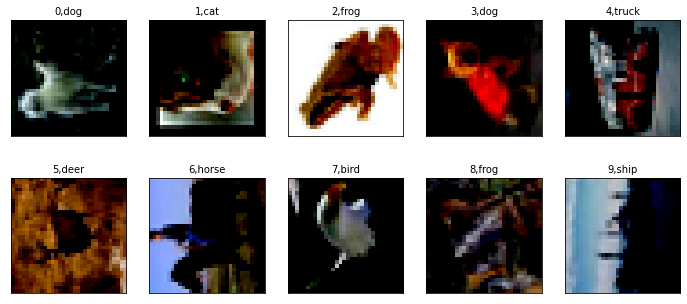

In [23]:
plt.figure()
plot_images_labels_prediction(x_train,y_train,[],0,10)

# Estudando resnet34

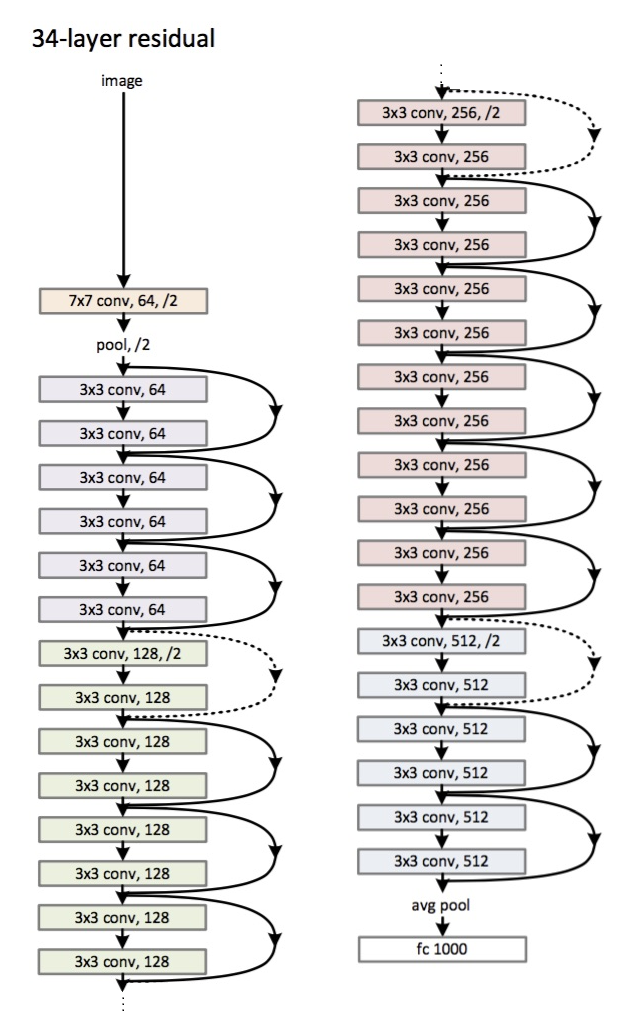

Fonte figura: https://www.analyticsvidhya.com/blog/2021/09/building-resnet-34-model-using-pytorch-a-guide-for-beginners/

In [24]:
from torchvision import models

In [25]:
# para ver uma layer específica: 
# list(models.resnet34().children())[4]
models.resnet34().parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


### Fórmula do tamanho da saída (F = Kernel size)

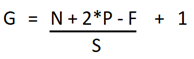

Maxpool 

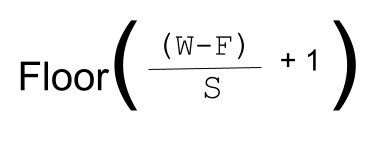

Somar ao W = W + 2*padding

# Implementações

## Implementando o Bloco Básico da Resnet

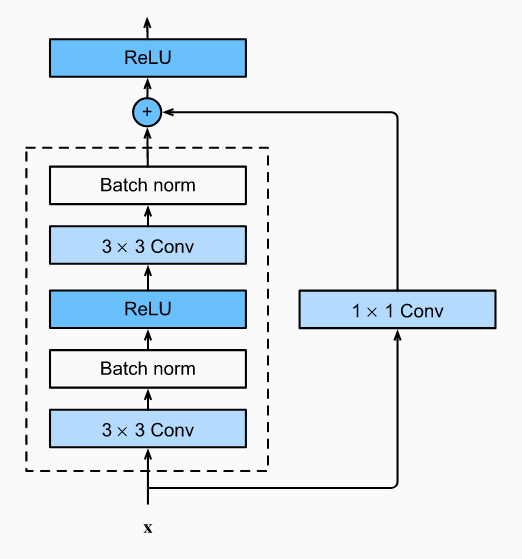

In [26]:
class MyBasicBlock(nn.Module):

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1
    ) -> None:
        """
        Percebido na descrição da resnet acima que: torchvision.models.resnet34().parameters
         as convoluções não possuem bias
         redução (opcional) ocorre na primeira conv3x3 e padding=1 e sem bias
         e padding=0 na conv 1x1 

        
        Nomes alterados para que dê certo load_state_dict
          conv3x3_x -> convx
          batchnorm_x -> bnx
          conv1x1 -> downsample

        Fonte apoio https://www.kaggle.com/code/poonaml/building-resnet34-from-scratch-using-pytorch/notebook

        Se há divergência nos canais de entrada e de saída ou stride (caso de mudança de dimensão), 
                cria-se uma projeção linear na identidade (indicado na figura da Resnet34 pela linha pontilhada)
        """
        super().__init__()
        # Escreva seu código aqui.
        self.in_channels = inplanes
        self.out_channels = planes
        self.stride = stride
        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=3 , stride=self.stride, 
                                   padding=1, dilation=1, groups=1,  bias=False, padding_mode='zeros')
        self.bn1 = nn.BatchNorm2d(num_features=self.out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = torch.nn.ReLU(inplace=False)
        self.conv2 = nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3 , stride=1, 
                                   padding=1, dilation=1, groups=1, bias=False, padding_mode='zeros')
        self.bn2 = nn.BatchNorm2d(num_features=self.out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        if (self.stride > 1 or inplanes != planes):
          self.se_downsample = True
          self.downsample = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=1 , stride=self.stride, 
                                 padding=0, dilation=1, groups=1, bias=False, padding_mode='zeros')
          # Outra opção dita no site seria  nn.Sequential(     conv2d +       nn.BatchNorm2d(planes),      )          
        else:
          self.se_downsample = False

    def forward(self, x: Tensor) -> Tensor:
        # Escreva seu código aqui.
        x_out = self.conv1(x)
        x_out = self.bn1(x_out)
        x_out = self.relu(x_out)
        x_out = self.conv2(x_out)
        x_out = self.bn2(x_out)
        if self.se_downsample:
          x_out += self.downsample(x)
        else:
          x_out += x
        x_out = self.relu(x_out)
        return x_out

### Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [27]:
height_in = 5
width_in = 5
inplanes = 2
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)

In [28]:
x.shape

torch.Size([1, 2, 5, 5])

In [29]:
downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

In [30]:
block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)
target_out = block_pt(x)
print(f'target_out.shape:\n{target_out.shape} target_out:\n{target_out}')


target_out.shape:
torch.Size([1, 3, 3, 3]) target_out:
tensor([[[[1.0362, 0.0000, 0.5027],
          [0.0000, 0.0000, 1.0111],
          [0.0969, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [1.3555, 1.7515, 0.0000],
          [0.0000, 0.0000, 0.1958]],

         [[0.0000, 0.2767, 0.4580],
          [0.7391, 1.1939, 1.0586],
          [0.9291, 0.0000, 0.0000]]]], grad_fn=<ReluBackward0>)


In [31]:
block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)


In [32]:
block_pt.parameters

<bound method Module.parameters of BasicBlock(
  (conv1): Conv2d(2, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample): Conv2d(2, 3, kernel_size=(1, 1), stride=(2, 2), bias=False)
)>

In [33]:
block.parameters

<bound method Module.parameters of MyBasicBlock(
  (conv1): Conv2d(2, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample): Conv2d(2, 3, kernel_size=(1, 1), stride=(2, 2), bias=False)
)>

In [34]:
# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(block_pt.state_dict())

<All keys matched successfully>

In [35]:
out = block(x)
print(f'out.shape:\n{out.shape} out:\n{out}')


out.shape:
torch.Size([1, 3, 3, 3]) out:
tensor([[[[1.0362, 0.0000, 0.5027],
          [0.0000, 0.0000, 1.0111],
          [0.0969, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [1.3555, 1.7515, 0.0000],
          [0.0000, 0.0000, 0.1958]],

         [[0.0000, 0.2767, 0.4580],
          [0.7391, 1.1939, 1.0586],
          [0.9291, 0.0000, 0.0000]]]], grad_fn=<ReluBackward0>)


In [36]:
assert torch.allclose(out, target_out, atol=1e-6)

## Definição de funções de apoio ao treinamento

In [143]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [160]:
def calcula_acertos(outputs, target, parm_criterion):
  # print(f'entrei calcula_acuracia outputs type: {type(outputs)} shape: {outputs.shape} target type: {type(target)} shape: {target.shape}')
  if isinstance(parm_criterion, torch.nn.CrossEntropyLoss):
    #print('é instancia de torch.nn.CrossEntropyLoss')
    preds = outputs.argmax(dim=1)
    return (preds == target).sum().item()  
  else:
    raise Exception("Critério não programado para cálculo de acertos")

In [145]:
def calcula_loss_tensor(outputs, target, parm_criterion):
  # print(f'entrei calcula_loss outputs type: {type(outputs)} shape: {outputs.shape} target type: {type(target)} shape: {target.shape}')
  if isinstance(parm_criterion, torch.nn.CrossEntropyLoss):
    #print('é instancia de torch.nn.CrossEntropyLoss')
    return parm_criterion(outputs, target)
  else:
    raise Exception("Critério não programado para cálculo de loss")    

In [161]:
def evaluation(model, loader, parm_criterion):
    # Escreva seu código aqui.
    model.eval()
    loss_total = 0
    acertos_total = 0
    with torch.no_grad():
        for cnt, (x_batch_valid, y_batch_valid) in enumerate(loader):
            x_batch_valid = x_batch_valid.to(hparam['device'])
            y_batch_valid = y_batch_valid.to(hparam['device'])

            # predict da rede
            outputs = model(x_batch_valid)

            # calcula a perda
            loss_batch = calcula_loss_tensor(outputs, y_batch_valid, parm_criterion)              
            acertos_batch = calcula_acertos(outputs, y_batch_valid, parm_criterion)
            
            # acumula nos batchs
            loss_total += loss_batch.item() 
            acertos_total += acertos_batch

        loss_validacao = loss_total / len(loader)
        acuracia_validacao = acertos_total / len(loader.dataset)
    print(f"loss_total/ len(loader.dataset): {loss_total}/{len(loader)} = {loss_validacao} #loss_validacao")
    print(f"acertos_total/ len(loader.dataset): {acertos_total}/{len(loader.dataset)} = {acuracia_validacao} #acuracia_validacao")
    # print(f'Evaluation: accuracy: {acuracia_validacao}, loss: {loss_validacao}')
    return loss_validacao, acuracia_validacao
   

In [179]:
def treina_modelo (parm_model, parm_loader_train, parm_loader_valid, parm_loader_test, hparam:dict, parm_tags_rastro:list, parm_se_um_batch_por_epoca:bool=False, parm_verbose:bool = True, parm_intervalo_print = 10):
  """
  """
  rastro_neptune = NeptuneRastroRun(hparam, parm_lista_tag=parm_tags_rastro)
  try:
    epochs = []
    loss_history = []
    total_trained_samples = 0
    history = []
    best_acuracia_validacao =0
    best_epoch = 0
    # Primeira avaliação com pesos aleatórios
    loss_validacao, acuracia_validacao =  evaluation(model=parm_model, loader=parm_loader_valid, parm_criterion= hparam['criterion'])
    metrica_rastro = {"valid/loss": loss_validacao,
                      "valid/acc": acuracia_validacao,
                      }  
    history.append(metrica_rastro)
    rastro_neptune.salva_metrica(metrica_rastro)

    time_inicio_treino = time.time()

    print(f'Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")} Métricas iniciais em validação: loss_validacao={loss_validacao}, acuracia_validacao={acuracia_validacao}')

    for cnt_epoca in range(1,hparam['max_epochs']+1):
        ultima_epoca_treinada = cnt_epoca
        accumulated_loss = 0
        acertos_total = 0
        parm_model.train()
        for x_batch_train, y_batch_train in tqdm(parm_loader_train, total=len(parm_loader_train), desc='Training'):
            x_batch_train = x_batch_train.to(hparam['device'])
            y_batch_train = y_batch_train.to(hparam['device'])

            
            # predict da rede
            outputs = parm_model(x_batch_train)

            # calcula a perda
            batch_loss = calcula_loss_tensor(outputs, y_batch_train, hparam['criterion'])

            # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
            hparam['optimizer'].zero_grad()
            batch_loss.backward()
            hparam['optimizer'].step()

            total_trained_samples += x_batch_train.size(0)
            epochs.append(total_trained_samples / len(parm_loader_train.dataset))
            loss_history.append(batch_loss.item())


            with torch.no_grad():
              # calcula a acurácia do batch
              acertos_batch = calcula_acertos(outputs, y_batch_train, hparam['criterion'])
              # acumula métricas
              accumulated_loss += batch_loss.item()
              acertos_total += acertos_batch 
            
            # apenas para teste da lógica, tratar um batch por época
            if parm_se_um_batch_por_epoca:
              break

        # ipdb.set_trace(context=8)
        loss_treino = accumulated_loss / len(parm_loader_train)
        acuracia_treino = acertos_total / len(parm_loader_train.dataset)

        # Chama a função de validação no final de cada época
        loss_validacao, acuracia_validacao = evaluation(model=parm_model, loader=parm_loader_valid, parm_criterion= hparam['criterion'])

        metrica_rastro = {"train/loss": loss_treino, 
                          "valid/loss": loss_validacao,
                          "train/acc": acuracia_treino, 
                          "valid/acc": acuracia_validacao,
                          }  

        history.append(metrica_rastro)

        rastro_neptune.salva_metrica(metrica_rastro)

        if parm_intervalo_print > 0:
          if (cnt_epoca)%parm_intervalo_print == 0: 
            print(f'Época: {(cnt_epoca):d}/{hparam["max_epochs"]:d}  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")} Train Loss: {loss_treino:.6f} accuracy: {acuracia_treino:.6f} Valid Loss: {loss_validacao:.6f} accuracy: {acuracia_validacao:.6f} ')


        # Salvando o melhor modelo de acordo com a loss de validação
        if acuracia_validacao > best_acuracia_validacao:
            best_model_dict = parm_model.state_dict()
            # torch.save(parm_model.state_dict(), 'best_model' + NeptuneRastroRun.retorna_tag_contexto_rastro() + '.pt')
            best_acuracia_validacao = acuracia_validacao
            best_epoch = cnt_epoca
            # print('best model')
        elif hparam['early_stop'] <= (cnt_epoca - best_epoch):
            print(f"Parando por critério de early_stop")
            break
    
    # calculando tempo gasto e médio por época
    tempo_treino = time.time() - time_inicio_treino   
    rastro_neptune.run_neptune["tempo_treino"].log(tempo_treino)
    rastro_neptune.run_neptune["tempo_treino_por_epoca"].log(tempo_treino/ultima_epoca_treinada)
    print(f"Tempo gasto total {tempo_treino:9.5f}, por época {tempo_treino/ultima_epoca_treinada:9.5f}")

    print(f'Final: {ultima_epoca_treinada:d}/{hparam["max_epochs"]:d}  Momento: {time.strftime("[%Y-%b-%d %H:%M:%S]")} Train Loss: {loss_treino:.6f} accuracy: {acuracia_treino:.6f} Valid Loss: {loss_validacao:.6f} accuracy: {acuracia_validacao:.6f} ')

    rastro_neptune.run_neptune["valid/best_epoch"].log(best_epoch)


    parm_model.load_state_dict(best_model_dict)
    parm_model.to(hparam['device'])
    loss_test, acuracia_test = evaluation(model=parm_model, loader=parm_loader_test, parm_criterion=hparam['criterion'] )

    metrica_rastro = {"teste/loss": loss_test,
                    "teste/acc": acuracia_test,
                    }  

    print(f" Resultado com dados de teste: {metrica_rastro}")
    rastro_neptune.salva_metrica(metrica_rastro)
    rastro_neptune.gera_grafico_modelo(parm_loader_train, parm_model)
  finally:
    rastro_neptune.stop()

  if parm_verbose:
  # Visualização usual da perda, somente no final de cada minibatch
    n_batches_train = len(train_dataloader)
    plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
    plt.xlabel('época')

  return {"acuracia_test":acuracia_test, "acuracia_treino":acuracia_treino, "best_acuracia_validacao":best_acuracia_validacao,  "best_epoch": best_epoch} #, "best_model_dict": best_model_dict}

## Modelo

Implemente um modelo de classificação que será treinado no CIFAR-10.

In [163]:
def make_layer(inplanes, planes, blocks, stride=1):
    """ 
    Para facilitar criação das camadas da rede, como em torchvision.models.resnet34() 
    Fonte: https://www.kaggle.com/code/poonaml/building-resnet34-from-scratch-using-pytorch/notebook
    """
    layers = []
    layers.append(MyBasicBlock(inplanes, planes, stride))
    inplanes = planes
    for _ in range(1, blocks):
        layers.append(MyBasicBlock(planes, planes))
    return nn.Sequential(*layers)

### Possíveis caminhos para tratar overfit (avaliar os casos)

data augmentation - translation of image

experimentar menos parâmetros




experimentar +dropout apos fc 



experimentar antes dropout: nn.Threshold(0, 1e-06)  # para evitar que pesos se aproximem muito dos dados



experimentar maxpool2d (não se prende ao detalhe, mas ao máximo)



kernel_regularizer é a função Regularizer que é aplicada à matriz de pesos do kernel.



bias_regularizer é a função Regularizer que é aplicada ao vetor de polarização.
activity_regularizer é a função Regularizer que é aplicada à saída da camada (ou seja, ativação).

### Criação Modelo

#### Sobre Adaptive Pooling 

In average-pooling or max-pooling, you essentially set the stride and kernel-size by your own, setting them as hyper-parameters. You will have to re-configure them if you happen to change your input size.

In Adaptive Pooling on the other hand, we specify the output size instead. And the stride and kernel-size are automatically selected to adapt to the needs. The following equations are used to calculate the value in the source code.



In [164]:
class ResNet34Like(torch.nn.Module):
    def __init__(self, verbose=False):
      """
      Se vai ser treinado no Cifar10, terá entrada torch.Size([n, 3, 32, 32])
      num_canais = 3
      image_height = 32, 
      image_weight = 32
      num_classes = 10

      Tentando implementar resnet34 conforme
      https://www.kaggle.com/code/poonaml/building-resnet34-from-scratch-using-pytorch/notebook 

         https://www.analyticsvidhya.com/blog/2021/09/building-resnet-34-model-using-pytorch-a-guide-for-beginners/

      """
      super().__init__()
      self.verbose = verbose
      self.num_canais_entrada = 3
      self.image_height = 32 
      self.image_width = 32
      self.num_classes = 10

      """
      original
      self.layer1 = nn.Sequential(nn.Conv2d(3,64,kernel_size=7, stride=2, padding=3, bias=False), #16,16
                       nn.BatchNorm2d(64),
                       nn.ReLU(inplace=True),
                       nn.MaxPool2d(kernel_size=3, stride=2, padding=1)) # 8, 8
      """
      #para evitar overfit: não reduzindo as dimensões altura e largura e sem maxpool2d
      self.layer1 = nn.Sequential(nn.Conv2d(3,64,kernel_size=7, stride=1, padding=3, bias=False), #32, 32
                       nn.BatchNorm2d(64),
                       nn.ReLU(inplace=True))

      self.layer2 = make_layer(inplanes=64,planes=64, stride=1, blocks=3) # sai 8 x 8
      self.layer3 = make_layer(64, 128, stride=1,blocks=4) # deveria ser stride=2, mas iria diminuir muito as dimensões

      self.layer4 = make_layer(128, 256, stride=1,blocks=6) # deveria ser stride=2, mas iria diminuir muito as dimensões
      self.layer5 = make_layer(256, 512, stride=1, blocks=3) # deveria ser stride=2, mas iria diminuir muito as dimensões
        
      self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
      self.full_connected = nn.Linear(512, self.num_classes)  # era para ser 512???
      
    def forward(self, x):
      assert x.shape[1]==self.num_canais_entrada, f"Numero de canais de entrada {x.shape[1]} diverge do esperado {self.num_canais_entrada} " 
      assert x.shape[2]==self.image_height, f"Image height de entrada {x.shape[1]} diverge do esperado {self.image_height} " 
      assert x.shape[3]==self.image_width, f"Image width de entrada {x.shape[1]} diverge do esperado {self.image_width} " 
      # Escreva seu código aqui.
      out = self.layer1(x)          # 32x32 anes:                             de 32x32 para 8x8 
      if self.verbose:
        print(f"Após layer1: out.shape = {out.shape}")
      out = self.layer2(out)          # mantido - original reduz pela metade
      if self.verbose:
        print(f"Após layer2: out.shape = {out.shape}")
      out = self.layer3(out)          # mantido - original reduz pela metade
      if self.verbose:
        print(f"Após layer3: out.shape = {out.shape}")
      
      out = self.layer4(out)          # mantido - original reduz pela metade
      if self.verbose:
        print(f"Após layer4: out.shape = {out.shape}")
      out = self.layer5(out)          # mantido - original reduz pela metade
      if self.verbose:
        print(f"Após layer5: out.shape = {out.shape}")

      out = self.avgpool(out)         # 1x1
      if self.verbose:
        print(f"Após avgpool: out.shape = {out.shape}")
      out = torch.flatten(out, 1)     # remove 1 X 1 grid and make vector of tensor shape 
      if self.verbose:
        print(f"Após flatten: out.shape = {out.shape}")
      out = self.full_connected(out)
      if self.verbose:
        print(f"Após full_connected: out.shape = {out.shape}")
      if self.verbose:
        raise Exception("Fim 1a passagem")
      return out

# Treinamento

## resnet 34 like: sem reduzir dimensões 32x32

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-60

{'acuracia_test': 0.8674, 'acuracia_treino': 1, 'best_acuracia_validacao': 0.8731, 'best_epoch': 58}

### Laço de treinamento

In [ ]:
# sempre inicializar os seeds antes para tornar os resultados comparáveis
inicializa_seed(123)
model = ResNet34Like()
model.to(hparam['device'])
print(f"modelo no device {hparam['device']}")

modelo no device cuda:0


In [ ]:
tag_rastro_experiencia_treino = 'resnet 34: sem reduzir dimensões 32x32'

In [ ]:
hparam['max_epochs'] = 60
hparam['early_stop'] = 8
hparam["learning_rate"] = 0.01
hparam['criterion'] = torch.nn.CrossEntropyLoss()
hparam['optimizer'] = torch.optim.SGD(model.parameters(), hparam["learning_rate"])
# só documentando:
hparam['num_classes']=10
hparam['tag_experimento_especifica'] = tag_rastro_experiencia_treino
hparam['num_parametros'] = count_parameters(model)
hparam['num_batchs_por_epoca'] = len(train_dataloader)
hparam['num_registros_dados_treino'] = len(train_dataloader.dataset)

In [ ]:
hparam

{'max_epochs': 60,
 'num_classes': 10,
 'num_workers_dataloader': 2,
 'batch_size': 50,
 'early_stop': 8,
 'learning_rate': 0.01,
 'criterion': CrossEntropyLoss(),
 'device': device(type='cuda', index=0),
 'train_size': 40000,
 'val_size': 10000,
 'optimizer': SGD (
 Parameter Group 0
     dampening: 0
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ),
 'tag_experimento_especifica': 'resnet 34: sem reduzir dimensões 32x32',
 'num_parametros': 21288010,
 'num_batchs_por_epoca': 800,
 'num_registros_dados_treino': 40000}

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-60
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Momento: [2022-May-11 15:08:10] Métricas iniciais em validação: loss_validacao=2.303433355093002, acuracia_validacao=0.0849


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 1/60  Momento: [2022-May-11 15:16:19] Train Loss: 1.480765 accuracy: 0.450175 Valid Loss: 1.749488 accuracy: 0.438800 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 2/60  Momento: [2022-May-11 15:24:27] Train Loss: 1.043775 accuracy: 0.624850 Valid Loss: 1.230097 accuracy: 0.578100 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 3/60  Momento: [2022-May-11 15:32:36] Train Loss: 0.834914 accuracy: 0.706275 Valid Loss: 1.579629 accuracy: 0.513100 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 4/60  Momento: [2022-May-11 15:40:44] Train Loss: 0.701298 accuracy: 0.755200 Valid Loss: 0.778138 accuracy: 0.729500 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 5/60  Momento: [2022-May-11 15:48:52] Train Loss: 0.594156 accuracy: 0.790800 Valid Loss: 0.967672 accuracy: 0.677100 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 6/60  Momento: [2022-May-11 15:57:00] Train Loss: 0.507043 accuracy: 0.823750 Valid Loss: 1.090741 accuracy: 0.661200 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 7/60  Momento: [2022-May-11 16:05:08] Train Loss: 0.440887 accuracy: 0.847575 Valid Loss: 0.714104 accuracy: 0.753400 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 8/60  Momento: [2022-May-11 16:13:16] Train Loss: 0.377756 accuracy: 0.867325 Valid Loss: 1.071104 accuracy: 0.667200 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 9/60  Momento: [2022-May-11 16:21:24] Train Loss: 0.326462 accuracy: 0.887700 Valid Loss: 0.693681 accuracy: 0.776500 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 10/60  Momento: [2022-May-11 16:29:32] Train Loss: 0.283370 accuracy: 0.901150 Valid Loss: 1.766953 accuracy: 0.630700 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 11/60  Momento: [2022-May-11 16:37:40] Train Loss: 0.237927 accuracy: 0.917600 Valid Loss: 0.685727 accuracy: 0.783200 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 12/60  Momento: [2022-May-11 16:45:49] Train Loss: 0.200444 accuracy: 0.930250 Valid Loss: 0.692107 accuracy: 0.791800 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 13/60  Momento: [2022-May-11 16:53:57] Train Loss: 0.174266 accuracy: 0.940350 Valid Loss: 0.723508 accuracy: 0.788000 


Training: 100%|██████████| 800/800 [07:28<00:00,  1.79it/s]


Época: 14/60  Momento: [2022-May-11 17:02:06] Train Loss: 0.146535 accuracy: 0.950175 Valid Loss: 0.811267 accuracy: 0.779400 


Training: 100%|██████████| 800/800 [07:28<00:00,  1.79it/s]


Época: 15/60  Momento: [2022-May-11 17:10:15] Train Loss: 0.125681 accuracy: 0.956175 Valid Loss: 0.660601 accuracy: 0.813900 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 16/60  Momento: [2022-May-11 17:18:23] Train Loss: 0.105010 accuracy: 0.963675 Valid Loss: 0.861953 accuracy: 0.779100 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 17/60  Momento: [2022-May-11 17:26:31] Train Loss: 0.090202 accuracy: 0.968575 Valid Loss: 1.357802 accuracy: 0.712100 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 18/60  Momento: [2022-May-11 17:34:39] Train Loss: 0.077163 accuracy: 0.974125 Valid Loss: 0.656363 accuracy: 0.821800 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 19/60  Momento: [2022-May-11 17:42:47] Train Loss: 0.069904 accuracy: 0.976300 Valid Loss: 0.738044 accuracy: 0.816600 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 20/60  Momento: [2022-May-11 17:50:55] Train Loss: 0.049355 accuracy: 0.984500 Valid Loss: 1.102996 accuracy: 0.760600 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 21/60  Momento: [2022-May-11 17:59:03] Train Loss: 0.048145 accuracy: 0.984300 Valid Loss: 0.905040 accuracy: 0.795500 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 22/60  Momento: [2022-May-11 18:07:11] Train Loss: 0.045893 accuracy: 0.984650 Valid Loss: 0.632501 accuracy: 0.841300 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 23/60  Momento: [2022-May-11 18:15:20] Train Loss: 0.034645 accuracy: 0.989025 Valid Loss: 0.962567 accuracy: 0.794000 


Training: 100%|██████████| 800/800 [07:28<00:00,  1.79it/s]


Época: 24/60  Momento: [2022-May-11 18:23:29] Train Loss: 0.039301 accuracy: 0.987000 Valid Loss: 0.716548 accuracy: 0.817300 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 25/60  Momento: [2022-May-11 18:31:37] Train Loss: 0.039628 accuracy: 0.986925 Valid Loss: 0.791007 accuracy: 0.822300 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 26/60  Momento: [2022-May-11 18:39:45] Train Loss: 0.026608 accuracy: 0.991950 Valid Loss: 0.859270 accuracy: 0.804900 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 27/60  Momento: [2022-May-11 18:47:54] Train Loss: 0.018844 accuracy: 0.994675 Valid Loss: 0.707962 accuracy: 0.846400 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 28/60  Momento: [2022-May-11 18:56:02] Train Loss: 0.008084 accuracy: 0.998425 Valid Loss: 0.627778 accuracy: 0.852800 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 29/60  Momento: [2022-May-11 19:04:11] Train Loss: 0.004187 accuracy: 0.999500 Valid Loss: 0.595736 accuracy: 0.863200 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 30/60  Momento: [2022-May-11 19:12:19] Train Loss: 0.002301 accuracy: 0.999800 Valid Loss: 0.613713 accuracy: 0.862500 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 31/60  Momento: [2022-May-11 19:20:27] Train Loss: 0.002182 accuracy: 0.999750 Valid Loss: 0.614905 accuracy: 0.864600 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 32/60  Momento: [2022-May-11 19:28:36] Train Loss: 0.001430 accuracy: 0.999950 Valid Loss: 0.593462 accuracy: 0.867300 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 33/60  Momento: [2022-May-11 19:36:44] Train Loss: 0.001146 accuracy: 0.999925 Valid Loss: 0.585894 accuracy: 0.869200 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 34/60  Momento: [2022-May-11 19:44:52] Train Loss: 0.000756 accuracy: 0.999975 Valid Loss: 0.591978 accuracy: 0.869100 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 35/60  Momento: [2022-May-11 19:53:00] Train Loss: 0.000729 accuracy: 0.999950 Valid Loss: 0.602472 accuracy: 0.867700 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 36/60  Momento: [2022-May-11 20:01:08] Train Loss: 0.000808 accuracy: 0.999950 Valid Loss: 0.601498 accuracy: 0.869100 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 37/60  Momento: [2022-May-11 20:09:16] Train Loss: 0.000499 accuracy: 1.000000 Valid Loss: 0.607243 accuracy: 0.869900 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 38/60  Momento: [2022-May-11 20:17:25] Train Loss: 0.000557 accuracy: 0.999975 Valid Loss: 0.606159 accuracy: 0.870500 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 39/60  Momento: [2022-May-11 20:25:33] Train Loss: 0.000609 accuracy: 0.999975 Valid Loss: 0.604899 accuracy: 0.870100 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 40/60  Momento: [2022-May-11 20:33:42] Train Loss: 0.000500 accuracy: 1.000000 Valid Loss: 0.603927 accuracy: 0.870900 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 41/60  Momento: [2022-May-11 20:41:50] Train Loss: 0.000454 accuracy: 1.000000 Valid Loss: 0.608015 accuracy: 0.867800 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 42/60  Momento: [2022-May-11 20:49:58] Train Loss: 0.000427 accuracy: 1.000000 Valid Loss: 0.610150 accuracy: 0.871000 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 43/60  Momento: [2022-May-11 20:58:07] Train Loss: 0.000484 accuracy: 0.999975 Valid Loss: 0.617600 accuracy: 0.869800 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 44/60  Momento: [2022-May-11 21:06:15] Train Loss: 0.000408 accuracy: 1.000000 Valid Loss: 0.624497 accuracy: 0.867000 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 45/60  Momento: [2022-May-11 21:14:23] Train Loss: 0.000349 accuracy: 1.000000 Valid Loss: 0.611214 accuracy: 0.871200 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 46/60  Momento: [2022-May-11 21:22:32] Train Loss: 0.000303 accuracy: 1.000000 Valid Loss: 0.613775 accuracy: 0.870700 


Training: 100%|██████████| 800/800 [07:28<00:00,  1.79it/s]


Época: 47/60  Momento: [2022-May-11 21:30:41] Train Loss: 0.000309 accuracy: 1.000000 Valid Loss: 0.621366 accuracy: 0.868800 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 48/60  Momento: [2022-May-11 21:38:49] Train Loss: 0.000225 accuracy: 1.000000 Valid Loss: 0.613885 accuracy: 0.871500 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 49/60  Momento: [2022-May-11 21:46:58] Train Loss: 0.000220 accuracy: 1.000000 Valid Loss: 0.614631 accuracy: 0.871700 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 50/60  Momento: [2022-May-11 21:55:06] Train Loss: 0.000261 accuracy: 1.000000 Valid Loss: 0.615886 accuracy: 0.870200 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 51/60  Momento: [2022-May-11 22:03:15] Train Loss: 0.000217 accuracy: 1.000000 Valid Loss: 0.625583 accuracy: 0.868600 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 52/60  Momento: [2022-May-11 22:11:23] Train Loss: 0.000211 accuracy: 1.000000 Valid Loss: 0.628798 accuracy: 0.868700 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 53/60  Momento: [2022-May-11 22:19:31] Train Loss: 0.000196 accuracy: 1.000000 Valid Loss: 0.619437 accuracy: 0.870000 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 54/60  Momento: [2022-May-11 22:27:39] Train Loss: 0.000221 accuracy: 1.000000 Valid Loss: 0.619001 accuracy: 0.870200 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 55/60  Momento: [2022-May-11 22:35:48] Train Loss: 0.000186 accuracy: 1.000000 Valid Loss: 0.616524 accuracy: 0.871100 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 56/60  Momento: [2022-May-11 22:43:56] Train Loss: 0.000201 accuracy: 1.000000 Valid Loss: 0.620769 accuracy: 0.870400 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 57/60  Momento: [2022-May-11 22:52:04] Train Loss: 0.000192 accuracy: 1.000000 Valid Loss: 0.623737 accuracy: 0.871900 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 58/60  Momento: [2022-May-11 23:00:12] Train Loss: 0.000178 accuracy: 1.000000 Valid Loss: 0.616341 accuracy: 0.873100 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 59/60  Momento: [2022-May-11 23:08:21] Train Loss: 0.000168 accuracy: 1.000000 Valid Loss: 0.616631 accuracy: 0.872100 


Training: 100%|██████████| 800/800 [07:27<00:00,  1.79it/s]


Época: 60/60  Momento: [2022-May-11 23:16:29] Train Loss: 0.000165 accuracy: 1.000000 Valid Loss: 0.635033 accuracy: 0.869000 
Tempo gasto total 29298.64693, por época 488.31078
Final: 60/60  Momento: [2022-May-11 23:16:29] Train Loss: 0.000165 accuracy: 1.000000 Valid Loss: 0.635033 accuracy: 0.869000 
 Resultado com dados de teste: {'teste/loss': 0.6199026496522129, 'teste/acc': 0.8674}
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.


All 3 operations synced, thanks for waiting!
Explore the metadata in Neptune UI:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-60


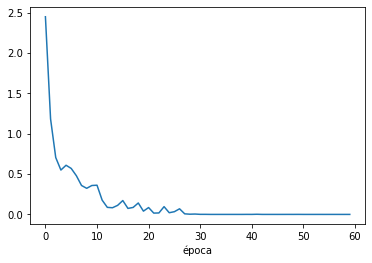

In [ ]:
resultado = treina_modelo(model, parm_loader_train=train_dataloader, parm_loader_valid=val_dataloader,
                          parm_loader_test=test_dataloader, hparam=hparam,
                          parm_tags_rastro=["aula6", tag_rastro_experiencia_treino],
                          parm_verbose=True, parm_intervalo_print=1)

In [ ]:
history, best_epoch, best_model_dict = resultado

In [ ]:
model.load_state_dict(best_model_dict)
model.to(hparam['device'])
best_epoch

58

In [ ]:
loss_test, acuracia_test = evaluation(model=model, loader=test_dataloader, parm_criterion=hparam['criterion'] )

In [ ]:
loss_test, acuracia_test

(0.6199026496522129, 0.8674)

# Bonus Opcional

## Implementando o Dropout

In [18]:
class MyDropout(torch.nn.Module):
    def __init__(self, p: float):
      # Escreva seu código aqui.
      # sobre distribuição binominal https://www.statisticshowto.com/probability-and-statistics/binomial-theorem/binomial-distribution-formula/
      super().__init__()
      if p < 0 or p > 1:
          raise ValueError("dropout probability has to be between 0 and 1, " "but got {}".format(p))
      self.p = p
      self.binomial = torch.distributions.binomial.Binomial(probs=1-self.p)

    def forward(self, x: torch.Tensor, training: bool):
      # Escreva seu código aqui.
      # Fonte: https://stackoverflow.com/questions/54109617/implementing-dropout-from-scratch
      if training: # aplicar dropout
          return x * self.binomial.sample(x.size()) * (1.0/(1-self.p))
          # por que multiplicar por binomial?
          #   é uma matriz com 0 e 1 onde haver tantos 1s quanto for (1-p)
          #   se p=0.25, a chance de manter o valor original (valor multiplicado por 1s) = 0.75 
          # por que multiplicar por (1.0/(1-self.p)):  (1.0/0.75) = 1.333
          # fonte https://www.quora.com/What-is-inverted-dropout
          #    So , value = value/keep_probs is done to scale up during the training so that we don't have to do anything special in the test phase aswell , and this is called inverted Dropout.
      return x


## Mostre que sua implementação traz resultados semelhantes à implementação do pytorch

In [10]:
import math
x = torch.rand(16, 3, 32, 32)


In [11]:
x.size()

torch.Size([16, 3, 32, 32])

In [12]:
torch.distributions.binomial.Binomial(probs=1-0.25).sample(x.size())[0]

tensor([[[1., 1., 1.,  ..., 0., 1., 1.],
         [1., 1., 0.,  ..., 1., 1., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [0., 1., 1.,  ..., 0., 0., 1.]],

        [[1., 1., 0.,  ..., 1., 1., 1.],
         [1., 1., 0.,  ..., 0., 0., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 0., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.]],

        [[1., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 0.],
         ...,
         [1., 0., 1.,  ..., 1., 1., 1.],
         [1., 1., 0.,  ..., 0., 1., 1.],
         [1., 1., 1.,  ..., 0., 1., 1.]]])

In [13]:
x[0]

tensor([[[0.4121, 0.7596, 0.3519,  ..., 0.4683, 0.3652, 0.6456],
         [0.2734, 0.6714, 0.4790,  ..., 0.9947, 0.8849, 0.0869],
         [0.8896, 0.9032, 0.7519,  ..., 0.7327, 0.1041, 0.0110],
         ...,
         [0.9921, 0.7336, 0.3115,  ..., 0.7316, 0.8785, 0.0365],
         [0.1298, 0.8667, 0.3315,  ..., 0.8996, 0.9992, 0.9648],
         [0.7980, 0.5873, 0.3428,  ..., 0.3099, 0.3204, 0.8025]],

        [[0.8650, 0.9940, 0.7035,  ..., 0.4337, 0.0961, 0.1234],
         [0.1916, 0.8703, 0.6494,  ..., 0.2438, 0.4858, 0.6305],
         [0.7784, 0.8817, 0.7607,  ..., 0.8480, 0.8366, 0.1406],
         ...,
         [0.6451, 0.3962, 0.0899,  ..., 0.9818, 0.5500, 0.6189],
         [0.4589, 0.5832, 0.6849,  ..., 0.6172, 0.7261, 0.4788],
         [0.9026, 0.3861, 0.9624,  ..., 0.7067, 0.4949, 0.9668]],

        [[0.7435, 0.4635, 0.6772,  ..., 0.3016, 0.6281, 0.2681],
         [0.1584, 0.4422, 0.5076,  ..., 0.0606, 0.6412, 0.6610],
         [0.1399, 0.4807, 0.1815,  ..., 0.1939, 0.3633, 0.

In [14]:
p = 0.5
dropout = MyDropout(p=p)

out = dropout(x, training=True)
mean_zeros = (out == 0).sum() / out.numel()

print(f'mean zeros: {mean_zeros}')


mean zeros: 0.49896240234375


In [15]:
out_pt = torch.nn.functional.dropout(x, p=p, training=True)
mean_zeros_pt = (out_pt == 0).sum() / out_pt.numel()
print(f'mean zeros pytorch: {mean_zeros_pt}')

mean zeros pytorch: 0.5030517578125


In [16]:
assert math.isclose(mean_zeros, mean_zeros_pt, abs_tol=1e-2)

In [17]:
out = dropout(x, training=False)
target_out = torch.nn.functional.dropout(x, p=p, training=False, inplace=False)
assert torch.allclose(out, target_out, atol=1e-6)

# Experimentações

## Execução em andamento (11/5/2022 21h46)

resnet 34: sem reduzir dimensões 32x32 com dropout25 antes fc e antes avgpool

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-78




## Versão menor de rede

In [ ]:
class Net(torch.nn.Module):
    """
      Visto que rede menor tende a não overfitar e alcançar bons resultados
      Optei por diminuir o número de parâmetros da rede.
      Fonte: resultados dos colegas Guilherme_Pereira e Leonardo_Pacheco
    """
    def __init__(self, verbose=False):
      """
      Se vai ser treinado no Cifar10, terá entrada torch.Size([n, 3, 32, 32])
      num_canais = 3
      image_height = 32, 
      image_weight = 32
      num_classes = 10

      Tentando implementar resnet34 conforme
      https://www.kaggle.com/code/poonaml/building-resnet34-from-scratch-using-pytorch/notebook 

         https://www.analyticsvidhya.com/blog/2021/09/building-resnet-34-model-using-pytorch-a-guide-for-beginners/

      """
      super(Net, self).__init__()
      self.verbose = verbose
      self.num_canais_entrada = 3
      self.image_height = 32 
      self.image_width = 32
      self.num_classes = 10

      #não reduzindo as dimensões altura e largura para evitar overfit e sem maxpool2d
      # self.layer1 = make_layer(inplanes=3,planes=16, stride=1, blocks=1) # não muda
      # self.layer2 = make_layer(inplanes=16,planes=32, stride=1, blocks=1) # não muda
      # self.layer3 = make_layer(inplanes=32,planes=64, stride=1, blocks=1) # não muda
      self.layer1 = MyBasicBlock(inplanes=3,planes=16, stride=1)
      self.layer2 = MyBasicBlock(inplanes=16,planes=32, stride=1) # não muda
      self.layer3 = MyBasicBlock(inplanes=32,planes=64, stride=1) # não muda
      # self.dropout_25 = nn.Dropout(p=0.25)    
      self.pooling = nn.MaxPool2d(kernel_size=2, stride=2, padding=1) # reduz pela metade dimensões + 1
      self.full_connected1 = nn.Linear(64*17*17, 64)
      self.full_connected2 = nn.Linear(64, self.num_classes)
      self.relu = torch.nn.ReLU()        
      
    def forward(self, x):
      """
        Blocos residuais de convolução aumentando canais em múltiplos de 2 até 64, maxpool apos blocos 3 e 4. Duas camadas fc. Dropout25 antes fcs.
      """
      assert x.shape[1]==self.num_canais_entrada, f"Numero de canais de entrada {x.shape[1]} diverge do esperado {self.num_canais_entrada} " 
      assert x.shape[2]==self.image_height, f"Image height de entrada {x.shape[1]} diverge do esperado {self.image_height} " 
      assert x.shape[3]==self.image_width, f"Image width de entrada {x.shape[1]} diverge do esperado {self.image_width} " 

      # Escreva seu código aqui.
      out = self.layer1(x)    # 32 x 32
      if self.verbose:
        print(f"Após layer 1: out.shape = {out.shape}")
      out = self.layer2(out)   #  
      if self.verbose:
        print(f"Após layer 2: out.shape = {out.shape}")
      out = self.layer3(out)   #  
      if self.verbose:
        print(f"Após layer 3: out.shape = {out.shape}")
      
      #comando para trace
      # ipdb.set_trace(context=8)
      out = self.pooling(out)   #  17x17 metade + 1
      if self.verbose:
        print(f"Após pooling: out.shape = {out.shape}")

      # out = self.pooling(out)   #  8x8
      #if self.verbose:
      #  print(f"Após pooling: out.shape = {out.shape}")
      
      # out = torch.flatten(out, 1)     # remove 1 X 1 grid and make vector of tensor shape 
      out = out.view(-1, 64*17*17) 

      if self.verbose:
        print(f"Após flatten: out.shape = {out.shape}")
      
      #out = self.dropout_25(out)
      out = self.full_connected1(out)
      if self.verbose:
        print(f"Após full_connected1: out.shape = {out.shape}")

      out = self.relu(out)
      
      #out = self.dropout_25(out)
      out = self.full_connected2(out)
      if self.verbose:
        print(f"Após full_connected1: out.shape = {out.shape}")
      if self.verbose:
        raise Exception("Fim 1a passagem")
      return out

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 11 22:31:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    30W /  70W |   1484MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Laço de treinamento

In [ ]:
# sempre inicializar os seeds antes para tornar os resultados comparáveis
inicializa_seed(123)
# model = ResNet34Like(verbose=False)
model = Net(verbose=False)
model.to(hparam['device'])
print(f"modelo no device {hparam['device']}")

modelo no device cuda:0


In [ ]:
tag_rastro_experiencia_treino = 'TESTE Blocos residuais de convolução aumentando canais em múltiplos de 2 até 32, maxpool apos blocos 3. Duas camadas fc. fc2 entra 64. Sem dropout. Nova tentativa2'

In [ ]:
hparam['max_epochs'] = 3
hparam['early_stop'] = 10
hparam["learning_rate"] = 0.01
hparam['criterion'] = torch.nn.CrossEntropyLoss()
hparam['optimizer'] = torch.optim.SGD(model.parameters(), hparam["learning_rate"])
# só documentando:
hparam['num_classes']=10
hparam['tag_experimento_especifica'] = tag_rastro_experiencia_treino
hparam['num_parametros'] = count_parameters(model)
hparam['num_batchs_por_epoca'] = len(train_dataloader)
hparam['num_registros_dados_treino'] = len(train_dataloader.dataset)

In [ ]:
hparam

{'max_epochs': 3,
 'num_classes': 10,
 'num_workers_dataloader': 2,
 'batch_size': 50,
 'early_stop': 10,
 'learning_rate': 0.01,
 'criterion': CrossEntropyLoss(),
 'device': device(type='cuda', index=0),
 'train_size': 40000,
 'val_size': 10000,
 'optimizer': SGD (
 Parameter Group 0
     dampening: 0
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ),
 'tag_experimento_especifica': 'TESTE Blocos residuais de convolução aumentando canais em múltiplos de 2 até 32, maxpool apos blocos 3. Duas camadas fc. fc2 entra 64. Sem dropout. Nova tentativa2',
 'num_parametros': 1259370,
 'num_batchs_por_epoca': 800,
 'num_registros_dados_treino': 40000}

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-89
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Momento: [2022-May-11 22:53:35] Métricas iniciais em validação: loss_validacao=2.3036366617679596, acuracia_validacao=0.0968


Training: 100%|██████████| 800/800 [00:11<00:00, 67.96it/s]


Época: 1/70  Momento: [2022-May-11 22:53:48] Train Loss: 1.492226 accuracy: 0.455200 Valid Loss: 1.261189 accuracy: 0.539000 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.20it/s]


Época: 2/70  Momento: [2022-May-11 22:54:02] Train Loss: 1.099293 accuracy: 0.606075 Valid Loss: 1.101182 accuracy: 0.608600 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.25it/s]


Época: 3/70  Momento: [2022-May-11 22:54:15] Train Loss: 0.934078 accuracy: 0.668275 Valid Loss: 0.951436 accuracy: 0.666100 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.00it/s]


Época: 4/70  Momento: [2022-May-11 22:54:29] Train Loss: 0.816278 accuracy: 0.712225 Valid Loss: 0.959862 accuracy: 0.666100 


Training: 100%|██████████| 800/800 [00:11<00:00, 66.93it/s]


Época: 5/70  Momento: [2022-May-11 22:54:43] Train Loss: 0.730243 accuracy: 0.743050 Valid Loss: 1.162070 accuracy: 0.610400 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.23it/s]


Época: 6/70  Momento: [2022-May-11 22:54:56] Train Loss: 0.639936 accuracy: 0.773775 Valid Loss: 0.999557 accuracy: 0.671200 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.41it/s]


Época: 7/70  Momento: [2022-May-11 22:55:10] Train Loss: 0.561117 accuracy: 0.804875 Valid Loss: 0.829420 accuracy: 0.713400 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.27it/s]


Época: 8/70  Momento: [2022-May-11 22:55:23] Train Loss: 0.487545 accuracy: 0.829250 Valid Loss: 1.083676 accuracy: 0.666300 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.31it/s]


Época: 9/70  Momento: [2022-May-11 22:55:37] Train Loss: 0.414015 accuracy: 0.856550 Valid Loss: 0.982667 accuracy: 0.682700 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.03it/s]


Época: 10/70  Momento: [2022-May-11 22:55:50] Train Loss: 0.340857 accuracy: 0.885600 Valid Loss: 0.997451 accuracy: 0.698200 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.15it/s]


Época: 11/70  Momento: [2022-May-11 22:56:04] Train Loss: 0.272550 accuracy: 0.908950 Valid Loss: 0.994177 accuracy: 0.702500 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.32it/s]


Época: 12/70  Momento: [2022-May-11 22:56:18] Train Loss: 0.212482 accuracy: 0.930625 Valid Loss: 1.032859 accuracy: 0.705000 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.16it/s]


Época: 13/70  Momento: [2022-May-11 22:56:31] Train Loss: 0.153476 accuracy: 0.952975 Valid Loss: 1.106697 accuracy: 0.697800 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.30it/s]


Época: 14/70  Momento: [2022-May-11 22:56:45] Train Loss: 0.108633 accuracy: 0.969050 Valid Loss: 1.117450 accuracy: 0.711400 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.28it/s]


Época: 15/70  Momento: [2022-May-11 22:56:58] Train Loss: 0.071768 accuracy: 0.983025 Valid Loss: 1.152345 accuracy: 0.709200 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.34it/s]


Época: 16/70  Momento: [2022-May-11 22:57:12] Train Loss: 0.043732 accuracy: 0.992800 Valid Loss: 1.201633 accuracy: 0.713900 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.25it/s]


Época: 17/70  Momento: [2022-May-11 22:57:26] Train Loss: 0.025306 accuracy: 0.997475 Valid Loss: 1.198153 accuracy: 0.724200 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.27it/s]


Época: 18/70  Momento: [2022-May-11 22:57:39] Train Loss: 0.014362 accuracy: 0.999350 Valid Loss: 1.227562 accuracy: 0.726400 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.08it/s]


Época: 19/70  Momento: [2022-May-11 22:57:53] Train Loss: 0.010578 accuracy: 0.999625 Valid Loss: 1.240950 accuracy: 0.726700 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.45it/s]


Época: 20/70  Momento: [2022-May-11 22:58:06] Train Loss: 0.007420 accuracy: 1.000000 Valid Loss: 1.274180 accuracy: 0.727400 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.22it/s]


Época: 21/70  Momento: [2022-May-11 22:58:20] Train Loss: 0.005873 accuracy: 0.999975 Valid Loss: 1.291653 accuracy: 0.726700 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.24it/s]


Época: 22/70  Momento: [2022-May-11 22:58:34] Train Loss: 0.004842 accuracy: 1.000000 Valid Loss: 1.318619 accuracy: 0.726900 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.09it/s]


Época: 23/70  Momento: [2022-May-11 22:58:47] Train Loss: 0.004285 accuracy: 0.999975 Valid Loss: 1.330013 accuracy: 0.726600 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.09it/s]


Época: 24/70  Momento: [2022-May-11 22:59:01] Train Loss: 0.003850 accuracy: 0.999975 Valid Loss: 1.355829 accuracy: 0.727100 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.17it/s]


Época: 25/70  Momento: [2022-May-11 22:59:14] Train Loss: 0.003415 accuracy: 0.999975 Valid Loss: 1.370042 accuracy: 0.727700 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.36it/s]


Época: 26/70  Momento: [2022-May-11 22:59:28] Train Loss: 0.003057 accuracy: 1.000000 Valid Loss: 1.380078 accuracy: 0.729800 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.08it/s]


Época: 27/70  Momento: [2022-May-11 22:59:42] Train Loss: 0.002876 accuracy: 0.999975 Valid Loss: 1.406768 accuracy: 0.729600 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.10it/s]


Época: 28/70  Momento: [2022-May-11 22:59:55] Train Loss: 0.002601 accuracy: 1.000000 Valid Loss: 1.399648 accuracy: 0.730100 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.28it/s]


Época: 29/70  Momento: [2022-May-11 23:00:09] Train Loss: 0.002353 accuracy: 1.000000 Valid Loss: 1.449134 accuracy: 0.724600 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.32it/s]


Época: 30/70  Momento: [2022-May-11 23:00:22] Train Loss: 0.002217 accuracy: 1.000000 Valid Loss: 1.425072 accuracy: 0.728400 


Training: 100%|██████████| 800/800 [00:11<00:00, 66.98it/s]


Época: 31/70  Momento: [2022-May-11 23:00:36] Train Loss: 0.002039 accuracy: 1.000000 Valid Loss: 1.426656 accuracy: 0.728400 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.05it/s]


Época: 32/70  Momento: [2022-May-11 23:00:50] Train Loss: 0.001901 accuracy: 1.000000 Valid Loss: 1.436256 accuracy: 0.728800 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.24it/s]


Época: 33/70  Momento: [2022-May-11 23:01:03] Train Loss: 0.001801 accuracy: 1.000000 Valid Loss: 1.449564 accuracy: 0.728100 


Training: 100%|██████████| 800/800 [00:12<00:00, 66.17it/s]


Época: 34/70  Momento: [2022-May-11 23:01:17] Train Loss: 0.001697 accuracy: 1.000000 Valid Loss: 1.464654 accuracy: 0.728500 


Training: 100%|██████████| 800/800 [00:11<00:00, 66.79it/s]


Época: 35/70  Momento: [2022-May-11 23:01:31] Train Loss: 0.001572 accuracy: 1.000000 Valid Loss: 1.471301 accuracy: 0.729400 


Training: 100%|██████████| 800/800 [00:12<00:00, 66.58it/s]


Época: 36/70  Momento: [2022-May-11 23:01:45] Train Loss: 0.001547 accuracy: 1.000000 Valid Loss: 1.470046 accuracy: 0.731600 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.26it/s]


Época: 37/70  Momento: [2022-May-11 23:01:58] Train Loss: 0.001448 accuracy: 1.000000 Valid Loss: 1.478358 accuracy: 0.729800 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.38it/s]


Época: 38/70  Momento: [2022-May-11 23:02:12] Train Loss: 0.001354 accuracy: 1.000000 Valid Loss: 1.488220 accuracy: 0.729700 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.27it/s]


Época: 39/70  Momento: [2022-May-11 23:02:25] Train Loss: 0.001308 accuracy: 1.000000 Valid Loss: 1.496323 accuracy: 0.729200 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.15it/s]


Época: 40/70  Momento: [2022-May-11 23:02:39] Train Loss: 0.001239 accuracy: 1.000000 Valid Loss: 1.504336 accuracy: 0.728700 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.01it/s]


Época: 41/70  Momento: [2022-May-11 23:02:53] Train Loss: 0.001335 accuracy: 0.999975 Valid Loss: 1.501904 accuracy: 0.728000 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.30it/s]


Época: 42/70  Momento: [2022-May-11 23:03:06] Train Loss: 0.001187 accuracy: 1.000000 Valid Loss: 1.526273 accuracy: 0.729200 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.04it/s]


Época: 43/70  Momento: [2022-May-11 23:03:20] Train Loss: 0.001120 accuracy: 1.000000 Valid Loss: 1.530230 accuracy: 0.728900 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.39it/s]


Época: 44/70  Momento: [2022-May-11 23:03:33] Train Loss: 0.001048 accuracy: 1.000000 Valid Loss: 1.518045 accuracy: 0.730200 


Training: 100%|██████████| 800/800 [00:11<00:00, 66.82it/s]


Época: 45/70  Momento: [2022-May-11 23:03:47] Train Loss: 0.001059 accuracy: 1.000000 Valid Loss: 1.530474 accuracy: 0.729700 


Training: 100%|██████████| 800/800 [00:11<00:00, 67.25it/s]


Época: 46/70  Momento: [2022-May-11 23:04:01] Train Loss: 0.000978 accuracy: 1.000000 Valid Loss: 1.536508 accuracy: 0.730300 
Parando por critério de early_stop
Tempo gasto total 625.99032, por época  13.60849
Final: 46/70  Momento: [2022-May-11 23:04:01] Train Loss: 0.000978 accuracy: 1.000000 Valid Loss: 1.536508 accuracy: 0.730300 
 Resultado com dados de teste: {'teste/loss': 1.501392382979393, 'teste/acc': 0.7304}
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 34 operations to synchronize with Neptune. Do not kill this process.


All 34 operations synced, thanks for waiting!
Explore the metadata in Neptune UI:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-89


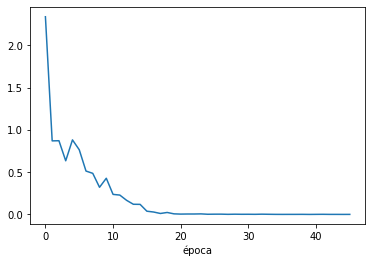

In [ ]:
resultado = treina_modelo(model, parm_loader_train=train_dataloader, parm_loader_valid=val_dataloader,
                          parm_loader_test=test_dataloader, hparam=hparam,
                          parm_tags_rastro=["aula6", tag_rastro_experiencia_treino],
                          parm_se_um_batch_por_epoca=False, parm_verbose=True, parm_intervalo_print=1)

In [ ]:
resultado


{'acuracia_test': 0.7304,
 'acuracia_treino': 1.0,
 'best_acuracia_validacao': 0.7316,
 'best_epoch': 36}

## Outros experimentos

### Blocos residuais de convolução aumentando canais em múltiplos de 2 até 32, maxpool apos bloco 3, deixando 17. Duas camadas fc. fc2 entra 64. Sem dropout

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-89

{'acuracia_test': 0.7304,
 'acuracia_treino': 1.0,
 'best_acuracia_validacao': 0.7316,
 'best_epoch': 36}

Blocos residuais de convolução aumentando canais em múltiplos de 2 até 64, maxpool apos blocos 3 e 4. Duas camadas fc. Sem dropout.

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-84

{'acuracia_test': 0.784,
 'acuracia_treino': 0.9999749660491943,
 'best_acuracia_validacao': 0.7861,
 'best_epoch': 25}

Blocos residuais de convolução aumentando canais em múltiplos de 2 até 64, maxpool apos blocos 3 e 4. Duas camadas fc. Dropout25 antes fcs.

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-83

{'acuracia_test': 0.7799,
 'acuracia_treino': 0.9537999629974365,
 'best_acuracia_validacao': 0.8019,
 'best_epoch': 29}

## resnet 34: reduzir dimensões 32x32 após layer 2; com dropout25 antes fc e antes avgpool

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-77

{'acuracia_test': 0.7907,
 'acuracia_treino': 0.9968249797821045,
 'best_acuracia_validacao': 0.8055,
 'best_epoch': 37}



## até layer 2 com cnn (1 bloco residual), max 64 canais, reduzindo dimensão nas layers, com avgpool após primeira, com dropout

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-74

{'acuracia_test': 0.6912,
 'acuracia_treino': 0.9008499979972839,
 'best_acuracia_validacao': 0.7128,
 'best_epoch': 46}

## até layer 2 com cnn (1 bloco residual), max 64 canais, sem avgpool, maxpool apos layers, dropout 50% antes fc

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-70

{'acuracia_test': 0.803, 'acuracia_treino': 1, 'best_acuracia_validacao': 0.7997, 'best_epoch': 72}

## até layer 2 com cnn, max 64 canais, sem avgpool, maxpool apos layers, dropout 50% antes fc

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-70

{'acuracia_test': 0.803,
 'acuracia_treino': 1,
 'best_acuracia_validacao': 0.7997,
 'best_epoch': 72}

### até layer 2 com cnn (1 bloco residual), max 64 canais, sem avgpool, maxpool apos layers, sem dropout

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-71

{'acuracia_test': 0.7845,
 'acuracia_treino': 1,
 'best_acuracia_validacao': 0.7836,
 'best_epoch': 39}

### até layer 2 com cnn, sem avgpool, maxpool apos layers, dropout 50% antes fc

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-66

{'acuracia_test': 0.6669, 'acuracia_treino': 1, 'best_acuracia_validacao': 0.7337, 'best_epoch': 13}

### até layer 2 com cnn, sem avgpool, maxpool apos layers, sem dropout

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-67

{'acuracia_test': 0.6629, 'acuracia_treino': 1, 'best_acuracia_validacao': 0.7779, 'best_epoch': 18}

### cnn até layer 5, layer1 da resnet, sem avgpool, maxpool apos layers 2, dropout 50% antes fc

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-63

{'acuracia_test': 0.6669, 'best_acuracia_validacao': 0.7337, 'best_epoch': 13}

### cnn resnet-like, reduzindo dimensões até 4x4 (layer3), com avgpool, sem dropout

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-62

{'acuracia_test': 0.6629, 'best_acuracia_validacao': 0.7779, 'best_epoch': 18}

### cnn até layer 3, sem avgpool, maxpool apos layers 1 e 2, dropout 50% antes fc

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-59

{'acuracia_test': 0.7971, 'best_acuracia_validacao': 0.7981, 'best_epoch': 30}

### cnn resnet só até layer 3, sem reduzir dimensões 32x32, dropout 50% antes e depois avgpool

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-57   (early stop)

{'acuracia_test': 0.6629, 'best_acuracia_validacao': 0.7779, 'best_epoch': 18}

### resnet 34: cnn só até layer 3, sem reduzir dimensões 32x32

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-53

### Tentativa 2 - resnet 34 sem alguns strides e sem última camada e sem diminuir dimensões altura e largura

In [ ]:
https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-46

### resnet 34 sem alguns strides e sem última camada

https://app.neptune.ai/marcusborela/IA025/e/COUNTXEMBE-44 

{'teste/acc': 0.7931, 'teste/loss': 1.3087301406264304}

# Rascunhos

In [ ]:
raise Exception("Abaixo só rascunho - não cabe execuções fora de contexto ")